# Load Dataset

In [13]:
import pandas as pd
from pathlib import Path

csv_path = Path('data') / 'ALL_aun_pacs210914.csv'
print('Attempting to read:', csv_path)
if not csv_path.exists():
    raise FileNotFoundError(f"{csv_path} not found. Current working dir: {Path.cwd()}")

df = pd.read_csv(csv_path)
print('Shape:', df.shape)
df.head()

Attempting to read: data\ALL_aun_pacs210914.csv
Shape: (15366, 164)


,pin,lang,gpaq1,gpaq2,P1,P2,P3a,P3bb,P3b,P4,...,ride_bicycle,by_bicycle,motorbike_three_wheel,sit_car,bus_van_pickup_taxi_schbus,train_metro,ferry,housing,sport_club,opinion_pa
0,1,EN-Bru,3,5,2,0,0,0,0,2,...,0,0,0,1,0,0,0,1,1,NaN
1,2,EN-Bru,2,1,2,0,0,0,0,2,...,0,0,0,0,0,0,0,2,2,NaN
2,3,EN-Bru,0,2,2,0,0,0,0,1,...,0,0,0,1,0,0,0,1,2,NaN
3,4,EN-Bru,7,3,2,0,0,0,0,1,...,0,0,0,1,0,0,0,1,2,NaN
4,5,EN-Bru,4,0,2,0,0,0,0,1,...,0,0,0,1,0,0,0,1,2,NaN


# Analysis: WEMWBS target and PA correlations
This cell computes a combined WEMWBS score, a bottom-quartile binary target, derives key physical-activity numeric features (hours→minutes conversions where needed), and computes Pearson and Spearman correlations between PA features and the WEMWBS total. Results are saved to `data/pa_wemwbs_correlations.csv`.

wemwbs_bin distribution (count, percent):
            count  percent
wemwbs_bin                
0            9092    59.17
1            6274    40.83


C:\Users\Palador-L014\AppData\Local\Temp\ipykernel_49700\3532750153.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_df.index.astype(str), y=summary_df['count'], palette='muted')


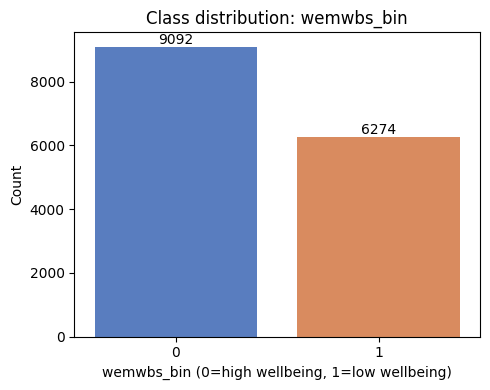

In [14]:
# Analysis cell -- compute targets, derive PA features, compute correlations
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from pathlib import Path
import scipy.stats as st
import json
import seaborn as sns

# def calculate_wemwbs_labels(df, random_state=42):
#     """
#     Calculates WEMWBS total, performs KMeans clustering,
#     assigns wellbeing classes, and returns the updated dataframe.
    
#     Output Labels:
#         0 = High wellbeing
#         1 = Low wellbeing
#     """
#     scores = df['wemwbs_total'].values.reshape(-1, 1)
#     kmeans = KMeans(n_clusters=2, random_state=random_state)
#     df['wemwbs_kmeans'] = kmeans.fit_predict(scores)

#     print("\nCluster means:\n", df.groupby('wemwbs_kmeans')['wemwbs_total'].mean())
#     cluster_means = df.groupby('wemwbs_kmeans')['wemwbs_total'].mean()
#     low_cluster = cluster_means.idxmin()
#     print("\nLow wellbeing cluster is:", low_cluster)

#     df['wemwbs_bin'] = (df['wemwbs_kmeans'] == low_cluster).astype(int)

#     return df

# Ensure dataframe is loaded (previous cell creates `df`)
if 'df' not in globals():
    csv_path = Path('data') / 'ALL_aun_pacs210914.csv'
    df = pd.read_csv(csv_path, na_values=['NA'])

# Identify WEMWBS items present
wem_cols = [f'wemwbs{i}' for i in range(1,8) if f'wemwbs{i}' in df.columns]
if not wem_cols:
    raise RuntimeError('No WEMWBS items found in dataframe (wemwbs1..7)')

# Compute total and mean (require at least 4 items present to compute total reliably)
df[wem_cols] = df[wem_cols].apply(pd.to_numeric, errors='coerce')

df['wemwbs_total'] = df[wem_cols].sum(axis=1, skipna=False)
# df = calculate_wemwbs_labels(df)
# 7 questions, 3x7=21 median score
threshold = 22
df['wemwbs_total'] = df[wem_cols].sum(axis=1, skipna=False)
df['wemwbs_bin'] = (df['wemwbs_total'] <= threshold).astype('Int64')
df['wemwbs_n_nonnull'] = df[wem_cols].notna().sum(axis=1)
# Option: require >=4 non-missing items to keep the row for target computation
df.loc[df['wemwbs_n_nonnull'] < 4, 'wemwbs_total'] = np.nan

# Compute counts and percentages (include NaNs if any)
counts = df['wemwbs_bin'].value_counts(dropna=False).sort_index()
total = counts.sum()
percent = (counts / total * 100).round(2)
summary_df = pd.DataFrame({'count': counts, 'percent': percent})
print('wemwbs_bin distribution (count, percent):')
print(summary_df)

# Plot a simple bar chart
plt.figure(figsize=(5,4))
sns.barplot(x=summary_df.index.astype(str), y=summary_df['count'], palette='muted')
plt.xlabel('wemwbs_bin (0=high wellbeing, 1=low wellbeing)')
plt.ylabel('Count')
plt.title('Class distribution: wemwbs_bin')
for i, v in enumerate(summary_df['count']):
    plt.text(i, v + max(summary_df['count']) * 0.01, str(int(v)), ha='center')
plt.tight_layout()
plt.show()

# Removing medium wellbeing rows
# print(df.shape)
# medium_min_threshold = 21
# medium_max_threshold = 26

# df = df[(df['wemwbs_total'] < medium_min_threshold) | (df['wemwbs_total'] > medium_max_threshold)]
# df['wemwbs_bin'] = (df['wemwbs_total'] > medium_max_threshold).astype(int)
# print(df.shape)

# counts = df['wemwbs_bin'].value_counts(dropna=False).sort_index()
# total = counts.sum()
# percent = (counts / total * 100).round(2)
# summary_df = pd.DataFrame({'count': counts, 'percent': percent})
# print('wemwbs_bin distribution after remove medium wellbeing (count, percent):')
# print(summary_df)
# print(df.shape)
# df = df[(df['wemwbs_total'] < 22) | (df['wemwbs_total'] > 25)]
# df['wemwbs_bin'] = (df['wemwbs_total'] > 25).astype(int)
# print(df.shape)

# counts = df['wemwbs_bin'].value_counts(dropna=False).sort_index()
# total = counts.sum()
# percent = (counts / total * 100).round(2)
# summary_df = pd.DataFrame({'count': counts, 'percent': percent})
# print('wemwbs_bin distribution (count, percent):')
# print(summary_df)

# plt.figure(figsize=(5,4))
# sns.barplot(x=summary_df.index.astype(str), y=summary_df['count'], palette='muted')
# plt.xlabel('wemwbs_bin (0=high wellbeing, 1=low wellbeing)')
# plt.ylabel('Count')
# plt.title('Class distribution: wemwbs_bin')
# for i, v in enumerate(summary_df['count']):
#     plt.text(i, v + max(summary_df['count']) * 0.01, str(int(v)), ha='center')
# plt.tight_layout()
# plt.show()

In [15]:
# Helper to convert hour fields to minutes if present
def hours_to_min(df, col):
    if col in df.columns:
        df[col + '_min'] = pd.to_numeric(df[col], errors='coerce') * 60

# Convert common 'hours' columns reported in notebook/data_dict
for hcol in ['P3a','P6a','P9a','P12a','P15a']:
    hours_to_min(df, hcol)

# Ensure minute columns are numeric for minute-based fields (P3b, P6b etc.)
for mcol in ['P3b','P6b','P9b','P12b','P15b','gpaq_sedent_m','gpaq1','gpaq2','hrs_slept','sport_total']:
    if mcol in df.columns:
        df[mcol] = pd.to_numeric(df[mcol], errors='coerce')

# Create an MVPA_total estimate from available minute columns (prefer *_min then *_b)
mvpa_parts = []
for prefix in ['P3','P6','P9','P12','P15']:
    if prefix + 'a_min' in df.columns:
        mvpa_parts.append(prefix + 'a_min')
    if prefix + 'b' in df.columns:
        mvpa_parts.append(prefix + 'b')
# Remove duplicates and keep only existing columns
mvpa_parts = [c for i,c in enumerate(mvpa_parts) if c in df.columns]
df['mvpa_total_min'] = df[mvpa_parts].sum(axis=1, skipna=True) if mvpa_parts else np.nan

#Candidate PA numeric features to correlate (select present columns)
# candidate_pa = [c for c in ['mvpa_total_min','sport_total','gpaq_sedent_m','gpaq1','gpaq2','hrs_slept'] if c in df.columns or c=='mvpa_total_min']
# candidate_pa = [c for c in candidate_pa if c in df.columns or c=='mvpa_total_min']
# # Add any other numeric columns whose names begin with common PA prefixes
# for c in df.columns:
#     low = c.lower()
#     if low.startswith(('run_jog','cycle','aerodance','ballgame','racquet','athletics','watersport','fightsport','p','gpaq')) and c not in candidate_pa:
#         # include if numeric-like
#         try:
#             pd.to_numeric(df[c], errors='raise')
#             candidate_pa.append(c)
#         except Exception:
#             pass
# family_features = [f's_family{i}' for i in range(1,12) if f's_family{i}' in df.columns]
# friend_features = [f's_friend{i}' for i in range(1,12) if f's_friend{i}' in df.columns]
# pa_opinion_features = [f'att{i}' for i in range(1,12) if f'att{i}' in df.columns]
# candidate_pa.extend(family_features)
# candidate_pa.extend(friend_features)
# candidate_pa.extend(pa_opinion_features)
# Select ALL numeric features from the dataframe
all_numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove the target columns so you don't correlate a feature with itself
remove_cols = ['wemwbs_total', 'wemwbs_bin', 'wemwbs_kmeans'] + wem_cols
candidate_features = [c for c in all_numeric_features if c not in remove_cols]
candidate_pa = candidate_features
# Correlation calculations
results = []
for feat in candidate_pa:
    x = pd.to_numeric(df[feat], errors='coerce')
    valid = x.notna() & df['wemwbs_total'].notna()
    if valid.sum() < 10:
        continue
    pr, pp = st.pearsonr(x[valid], df.loc[valid, 'wemwbs_total'])
    sr, sp = st.spearmanr(x[valid], df.loc[valid, 'wemwbs_total'])
    # point-biserial via pearson between numeric feat and binary target
    valid_bin = x.notna() & df['wemwbs_bin'].notna()
    if valid_bin.sum() >= 10:
        br, bp = st.pearsonr(x[valid_bin], df.loc[valid_bin, 'wemwbs_bin'].astype(float))
    else:
        br, bp = (np.nan, np.nan)
    results.append({'feature': feat, 'pearson_r': pr, 'pearson_p': pp, 'spearman_r': sr, 'spearman_p': sp, 'biserial_r': br, 'biserial_p': bp, 'n': int(valid.sum())})

res_df = pd.DataFrame(results).sort_values(by='pearson_r', key=lambda s: s.abs(), ascending=False)

# Add feature descriptions to the correlation results
def get_feature_description(feature_name):
    data_dict_path = Path('data') / 'data_dictionary.json'
    if data_dict_path.exists():
        with open(data_dict_path, 'r') as f:
            descriptions = json.load(f)
        return descriptions.get(feature_name, 'Description not available')
    else:
        print(f"Warning: {data_dict_path} not found. Using default descriptions.")
        default_descriptions = {
            'mvpa_total_min': 'Total minutes of moderate-to-vigorous physical activity',
            'sport_total': 'Total minutes spent on sports activities',
            'gpaq_sedent_m': 'Minutes spent in sedentary activities (GPAQ)',
            'gpaq1': 'GPAQ question 1 response',
            'gpaq2': 'GPAQ question 2 response',
            'hrs_slept': 'Hours of sleep per day'
        }
        return default_descriptions.get(feature_name, 'Description not available')

res_df['desc'] = res_df['feature'].apply(get_feature_description)

# Summary stats for WEMWBS total
wem_summary = df['wemwbs_total'].describe()
print('WEMWBS total summary: ', wem_summary)

# Save the updated results to CSV
output_path = Path('data') / 'pa_wemwbs_correlations.csv'
res_df.to_csv(output_path, index=False)
print(f"Updated correlation results saved to {output_path}")

# Show top correlations
display(res_df.head(20))

WEMWBS total summary:  count    15366.000000
mean        23.472862
std          4.589098
min          7.000000
25%         21.000000
50%         24.000000
75%         27.000000
max         35.000000
Name: wemwbs_total, dtype: float64
Updated correlation results saved to data\pa_wemwbs_correlations.csv


C:\Users\Palador-L014\AppData\Local\Temp\ipykernel_49700\3427429413.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pr, pp = st.pearsonr(x[valid], df.loc[valid, 'wemwbs_total'])
C:\Users\Palador-L014\AppData\Local\Temp\ipykernel_49700\3427429413.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sr, sp = st.spearmanr(x[valid], df.loc[valid, 'wemwbs_total'])
C:\Users\Palador-L014\AppData\Local\Temp\ipykernel_49700\3427429413.py:64: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  br, bp = st.pearsonr(x[valid_bin], df.loc[valid_bin, 'wemwbs_bin'].astype(float))


,feature,pearson_r,pearson_p,spearman_r,spearman_p,biserial_r,biserial_p,n,desc
98,att1,0.206247,2.951577e-147,0.216381,3.108119e-162,-0.170888,4.969353e-101,15366,"{'question_number': 'Q48_1', 'description': 'H..."
102,att5,0.188429,8.380960e-123,0.190096,5.453342e-125,-0.142446,1.828480e-70,15366,"{'question_number': 'Q48_5', 'description': 'H..."
101,att4,0.173332,6.281731e-104,0.167832,1.818625e-97,-0.128506,1.393258e-57,15366,"{'question_number': 'Q48_4', 'description': 'H..."
114,s_family12,0.170642,9.687717e-101,0.180483,1.166792e-112,-0.149793,8.341552e-78,15366,"{'question_number': 'Q49#1_12', 'description':..."
81,panes2,-0.149789,8.412543e-78,-0.173942,1.170536e-104,0.136210,1.561170e-64,15366,"{'question_number': 'Q30', 'description': 'Ove..."
126,s_friend12,0.147674,1.194450e-75,0.155372,1.228199e-83,-0.121909,5.831400e-52,15366,"{'question_number': 'Q49#2_12', 'description':..."
1,gpaq1,0.142050,4.433472e-70,0.148172,3.742563e-76,-0.115774,5.279900e-47,15366,"{'question_number': 'Q7', 'description': 'In t..."
115,s_friend1,0.138834,5.383343e-67,0.143185,3.476415e-71,-0.111659,7.972986e-44,15366,"{'question_number': 'Q49#2_1', 'description': ..."
104,s_family2,0.134708,3.811466e-63,0.138493,1.131851e-66,-0.114111,1.050584e-45,15366,"{'question_number': 'Q49#1_2', 'description': ..."
116,s_friend2,0.133361,6.485718e-62,0.137643,7.165040e-66,-0.106093,1.036880e-39,15366,"{'question_number': 'Q49#2_2', 'description': ..."


# Feature Engineering Step
This step preprocesses the dataset by handling missing values, scaling numeric features, and encoding categorical features. The preprocessing pipeline ensures the data is ready for modeling.

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib

# Extract target and drop rows with missing target to avoid leakage
if 'wemwbs_bin' in df.columns:
    y = df['wemwbs_bin']
    keep_idx = y.notna()
    y = y.loc[keep_idx]
    df = df.loc[keep_idx].copy()
    print(f'Extracted target "wemwbs_bin" and kept {df.shape[0]} rows')
else:
    raise RuntimeError('Target column "wemwbs_bin" not found. Run the analysis cell first.')
# Drop environment-related and unused columns that start with 'panes' first (these are not features)
# panes_cols = [c for c in df.columns if c.lower().startswith('panes') or c=='pin']
# if panes_cols:
#     print('Dropping environment-related columns:', panes_cols)
#     df = df.drop(columns=panes_cols)
# else:
#     print("No environment-related or pin columns found to drop.")
df = df.drop(columns='pin')

# If a correlation results dataframe `res_df` exists, use its features to subset `df`
selected_features = None
if 'res_df' in globals() and isinstance(res_df, (pd.DataFrame,)) and 'feature' in res_df.columns:
    n_total = len(res_df)
    n_keep = int(n_total * 0.7)   # 70% selection

    top_features = res_df['feature'].head(n_keep).tolist()
    print('Features from importances (requested):', top_features)
    # Keep only features that exist in df
    use_cols = [c for c in top_features if c in df.columns]
    missing = [c for c in top_features if c not in df.columns]
    if missing:
        print('Warning - these top features were not found in df and will be skipped:', missing)
    # Ensure common derived PA columns are included if present (e.g., mvpa_total_min)
    for derived in ['mvpa_total_min','sport_total','gpaq_sedent_m','hrs_slept']:
        if derived in df.columns and derived not in use_cols:
            use_cols.append(derived)
    if not use_cols:
        print('No features present in dataframe; keeping all columns instead.')
        X_df = df.copy()
    else:
        selected_features = use_cols
        # IMPORTANT: do not include the target column in X_df
        X_df = df[use_cols].copy()
        print('X_df.shape after subsetting to selected features (rows, cols):', X_df.shape)
else:
    print("No 'res_df' with a 'feature' column found; not subsetting by top features.")
    X_df = df.copy()
# Show remaining columns (first 50 for readability)
print('Feature columns count:', len(X_df.columns))
print('Sample feature columns:', list(X_df.columns[:50]))

Extracted target "wemwbs_bin" and kept 15366 rows
Features from importances (requested): ['att1', 'att5', 'att4', 's_family12', 'panes2', 's_friend12', 'gpaq1', 's_friend1', 's_family2', 's_friend2', 'panes5', 's_friend7', 's_friend4', 's_friend5', 's_friend8', 'panes4', 's_friend10', 's_family1', 's_family10', 's_friend9', 's_family5', 'P14', 'P13', 's_friend3', 's_friend6', 's_family3', 'panes8', 's_family7', 's_family9', 's_family8', 's_family4', 's_family6', 's_friend11', 'panes6', 's_family11', 'P15a_min', 'P15bb', 'P15a', 'panes10', 'sit_car', 'mvpa_total_min', 'panes9', 'hrb_diet2', 'panes7', 'sport_club', 'P15b', 'hrb_diet1', 'sport_total', 'field2', 'panes1', 'height', 'P10', 'P11', 'field', 'sport_cat', 'gpaq_sedent_h', 'gpaq_sedent_m', 'ballgame', 'att3', 'cycle', 'watersport', 'P12b', 'P12a_min', 'P12bb', 'P12a', 'athletics', 'by_bicycle', 'P8', 'racquet', 'ballgame_wkdy', 'fightsport', 'gpaq_sedent_h_cat', 'att2', 'P9b', 'hrb_diet3', 'campus', 'P9a', 'P9bb', 'P9a_min', 'fi

In [17]:
# Identify numeric and categorical features from the feature-only DataFrame
numeric_features = X_df.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_df.select_dtypes(include=['object', 'category']).columns.tolist()
# Define preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')) ,
    ('scaler', StandardScaler())
])
# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')) ,
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
# Apply the preprocessing pipeline to feature-only DataFrame
processed_X = preprocessor.fit_transform(X_df)
print("Preprocessing complete. Transformed data shape:", processed_X.shape)
# Save feature names for later mapping (SHAP / importances)
try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    feature_names = None
if feature_names is not None:
    joblib.dump(feature_names, 'feature_names.pkl')
    print('Saved feature names to feature_names.pkl')

Preprocessing complete. Transformed data shape: (15366, 110)
Saved feature names to feature_names.pkl


# Model and Evaluation 


XGBoost Evaluation:
Best XGBoost pipeline saved as 'best_XGBoost_pipeline.pkl'
Classification Report:
              precision    recall  f1-score   support

        High       0.69      0.80      0.74      1819
         Low       0.62      0.49      0.55      1255

    accuracy                           0.67      3074
   macro avg       0.66      0.64      0.64      3074
weighted avg       0.67      0.67      0.66      3074

Test macro-F1: 0.6449


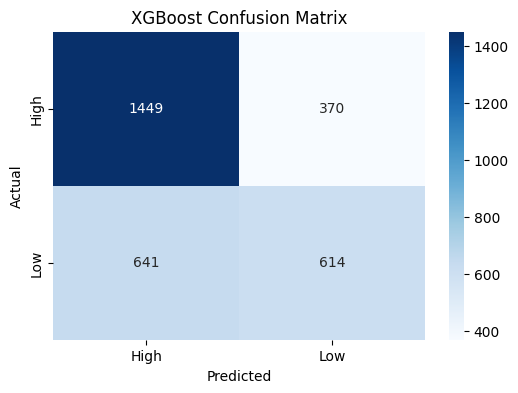

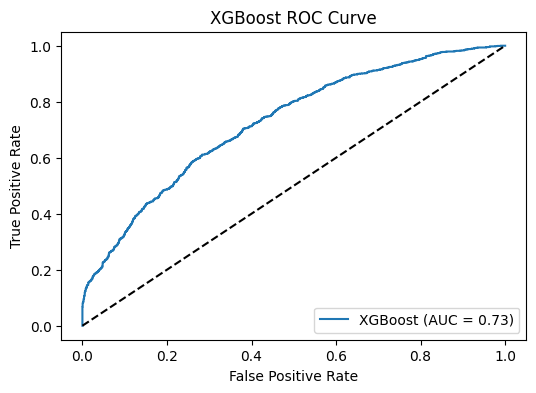

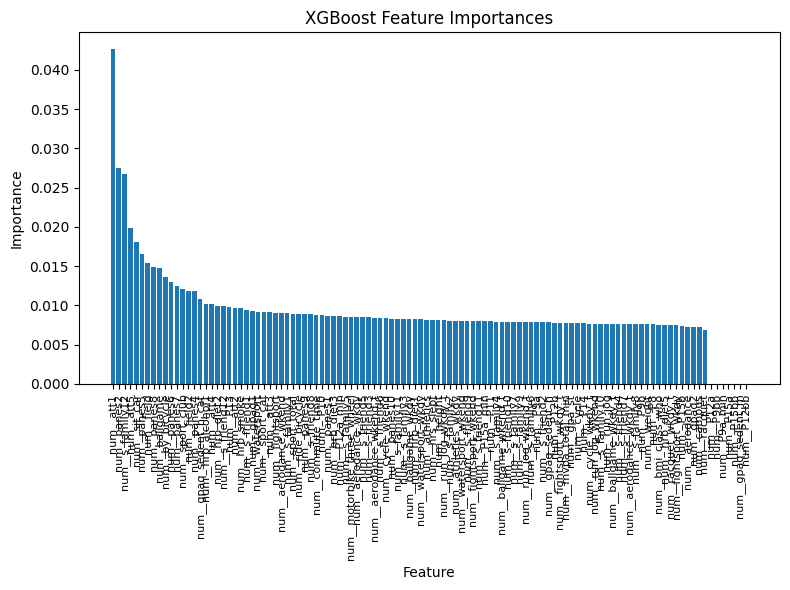

- Top features influencing the model:
  num__att1: Importance 0.0426
  num__panes2: Importance 0.0276
  num__s_family12: Importance 0.0267
  num__att5: Importance 0.0198
  num__sit_car: Importance 0.0180
  num__panes5: Importance 0.0166
  num__field: Importance 0.0154
  num__panes8: Importance 0.0149
  num__ballgame: Importance 0.0148
  num__by_bicycle: Importance 0.0136

RandomForest Evaluation:
Best RandomForest pipeline saved as 'best_RandomForest_pipeline.pkl'
Classification Report:
              precision    recall  f1-score   support

        High       0.70      0.76      0.73      1819
         Low       0.61      0.53      0.57      1255

    accuracy                           0.67      3074
   macro avg       0.65      0.65      0.65      3074
weighted avg       0.66      0.67      0.66      3074

Test macro-F1: 0.6482


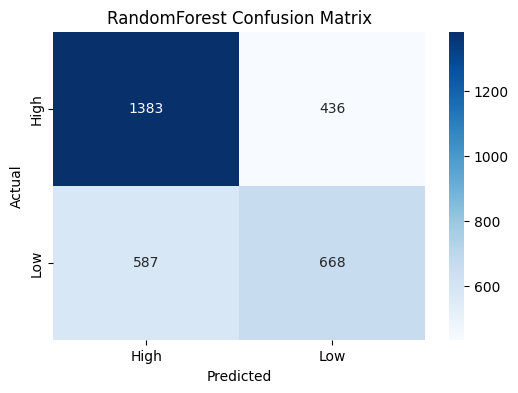

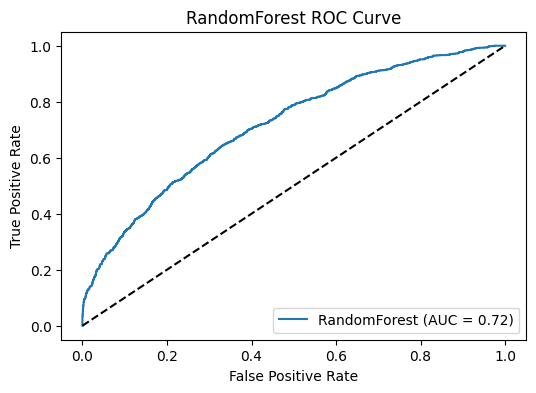

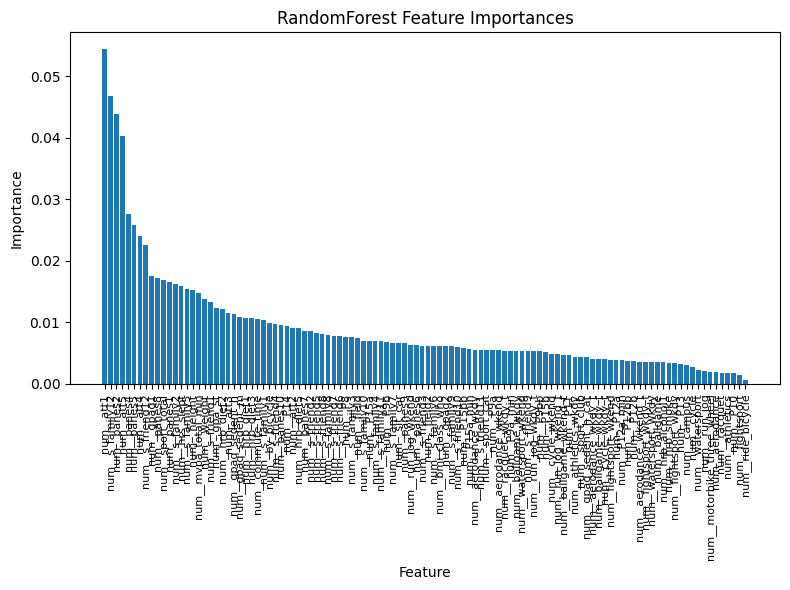

- Top features influencing the model:
  num__att1: Importance 0.0545
  num__s_family12: Importance 0.0468
  num__panes2: Importance 0.0439
  num__att5: Importance 0.0403
  num__panes4: Importance 0.0276
  num__panes5: Importance 0.0258
  num__att4: Importance 0.0241
  num__s_friend12: Importance 0.0225
  num__gpaq1: Importance 0.0175
  num__panes8: Importance 0.0171

KNN Evaluation:
Best KNN pipeline saved as 'best_KNN_pipeline.pkl'
Classification Report:
              precision    recall  f1-score   support

        High       0.72      0.41      0.52      1819
         Low       0.47      0.77      0.59      1255

    accuracy                           0.56      3074
   macro avg       0.60      0.59      0.55      3074
weighted avg       0.62      0.56      0.55      3074

Test macro-F1: 0.5541


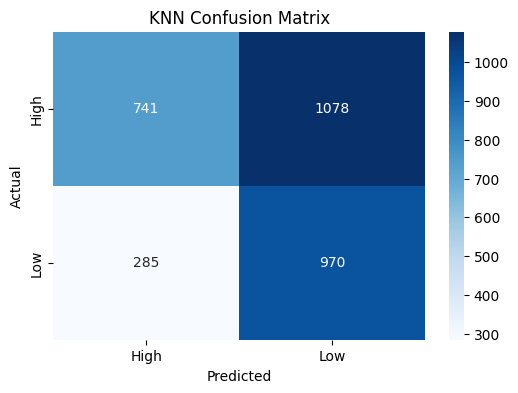

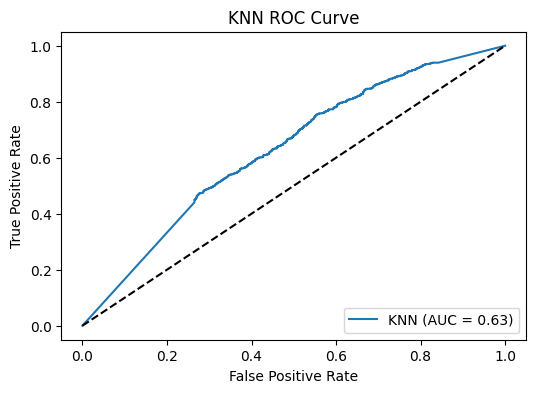

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
# For SMOTE resampling and imbalanced-aware pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter

# Split the data into training and testing sets
X = processed_X
y = y.values  # aligned target array
# Use stratified split to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Use stratified K-fold for cross-validation and prioritize recall
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# NOTE: SMOTE will be applied inside cross-validation using an imblearn Pipeline
# (This prevents data leakage from applying SMOTE before CV folds.)
classifiers = {
    'XGBoost': (XGBClassifier(eval_metric='logloss', verbosity=0), {
        "n_estimators": [300, 400, 500],
        "max_depth": [6, 8, 10],
        "learning_rate": [0.03, 0.05, 0.07],
        "subsample": [0.7],
    }),
    'RandomForest': (RandomForestClassifier(class_weight='balanced', random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }),
}
# Attempt to get feature names (sklearn >=1.0) for interpretation/importance mapping
try:
    feature_names = joblib.load('feature_names.pkl')
except Exception:
    try:
        feature_names = preprocessor.get_feature_names_out()
    except Exception:
        feature_names = None
# Perform hyperparameter tuning and evaluate models (scoring='f1_macro')
for name, (model, params) in classifiers.items():
    print(f"\n{name} Evaluation:")
    # Build an imbalanced-aware pipeline that applies SMOTE inside each CV fold
    pipeline_clf = ImbPipeline([('smote', SMOTE(random_state=42)), ('model', model)])
    # Prefix the model hyperparameters so GridSearchCV targets the inner estimator
    param_grid = {f'model__{k}': v for k, v in params.items()}
    # Optimize for macro-F1 to balance performance across both classes
    grid_search = GridSearchCV(pipeline_clf, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_pipeline = grid_search.best_estimator_
    # Extract the trained inner model for saving into a full preprocessor+model pipeline
    try:
        best_model = best_pipeline.named_steps['model']
    except Exception:
        best_model = best_pipeline
    # Save the full pipeline (preprocessor + trained model) for later use
    deploy_pipeline = Pipeline([('preprocessor', preprocessor), ('model', best_model)])
    joblib.dump(deploy_pipeline, f'best_{name}_pipeline.pkl')
    if feature_names is not None:
        joblib.dump(feature_names, f'feature_names_{name}.pkl')
    print(f"Best {name} pipeline saved as 'best_{name}_pipeline.pkl'")

    # Predictions and classification report (use the best_pipeline which expects processed arrays)
    y_pred = best_pipeline.predict(X_test)
    print("Classification Report:")
    # Ensure target names match encoding: 0 -> High, 1 -> Low
    target_names = ['High', 'Low']
    print(classification_report(y_test, y_pred, target_names=target_names))
    # Print macro-F1 explicitly
    test_macro_f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Test macro-F1: {test_macro_f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{name} ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

    # Feature importance (if applicable) - print names if available
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(8, 6))
        # map indices to names when possible
        if feature_names is not None and len(feature_names) == len(importances):
            names = [feature_names[i] for i in indices]
            plt.bar(range(len(importances)), importances[indices], align='center')
            plt.xticks(range(len(importances)), names, rotation=90, fontsize=8)
        else:
            plt.bar(range(len(importances)), importances[indices], align='center')
        plt.title(f'{name} Feature Importances')
        plt.xlabel('Feature')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()
        # Print top named features
        print('- Top features influencing the model:')
        for i in range(min(10, len(importances))):
            idx = indices[i]
            fname = feature_names[idx] if feature_names is not None and idx < len(feature_names) else f'feature_{idx}'
            print(f"  {fname}: Importance {importances[idx]:.4f}")


# Shap Interpretation

C:\Users\Palador-L014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



SHAP Interpretation Phase:



XGBoost Interpretation on Best Model:
Loaded pipeline from best_XGBoost_pipeline.pkl
SHAP values computed for XGBoost: True

RandomForest Interpretation on Best Model:
Loaded pipeline from best_RandomForest_pipeline.pkl
SHAP values computed for RandomForest: True
Plot error: Feature and SHAP matrices must have the same number of rows!

KNN Interpretation on Best Model:
Loaded pipeline from best_KNN_pipeline.pkl
SHAP values computed for KNN: False


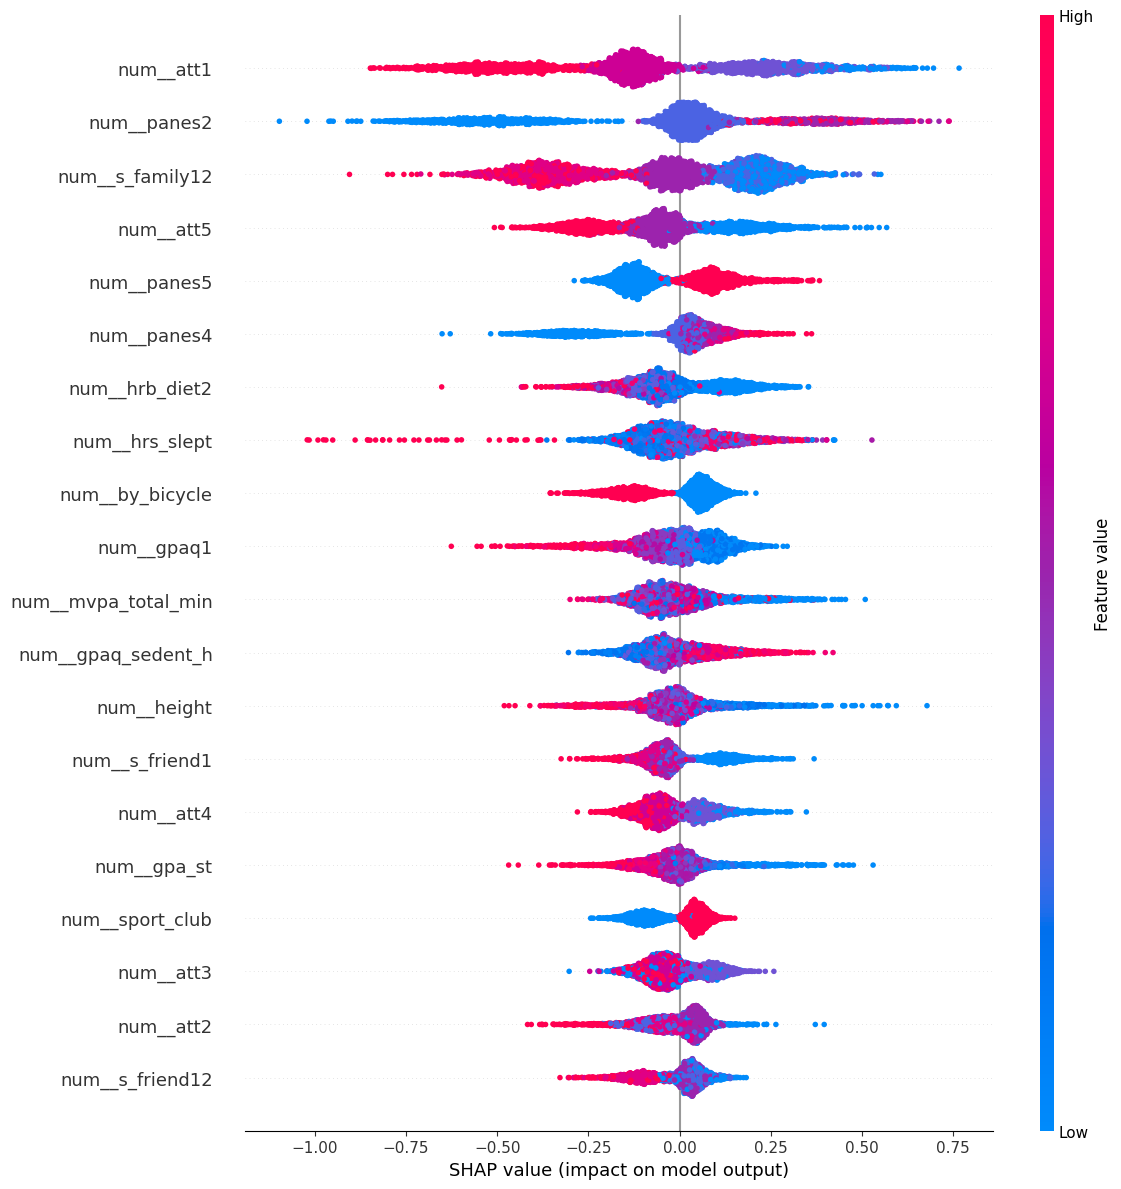

<Figure size 600x1200 with 0 Axes>

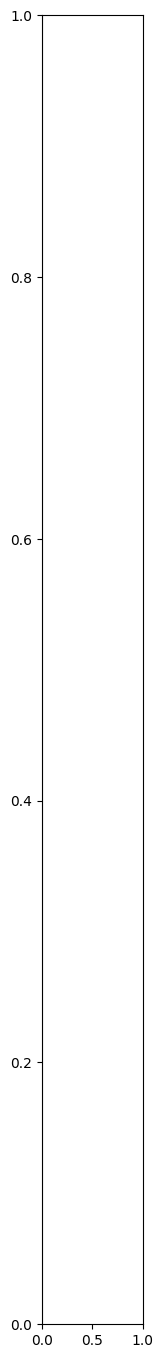

In [19]:
import shap
import matplotlib.pyplot as plt
import joblib
import pandas as pd

print('\nSHAP Interpretation Phase:', flush=True)
shap.initjs()
for name, (model, params) in classifiers.items():
    print(f"\n{name} Interpretation on Best Model:")
    pipeline_path = f'best_{name}_pipeline.pkl'
    best_model = None
    preprocessor_loaded = None
    try:
        pipeline = joblib.load(pipeline_path)
        print(f'Loaded pipeline from {pipeline_path}')
        if hasattr(pipeline, 'named_steps') and 'model' in pipeline.named_steps:
            best_model = pipeline.named_steps['model']
            preprocessor_loaded = pipeline.named_steps.get('preprocessor', None)
        else:
            best_model = pipeline
    except Exception as e:
        print('Failed to load pipeline, attempting to load model-only:', e)
        try:
            best_model = joblib.load(f'best_{name}_model.pkl')
        except Exception as e2:
            print('Also failed to load model-only:', e2)
            best_model = None
    # Attempt to get feature names from per-model file, fallback to global file or preprocessor
    try:
        feature_names = joblib.load(f'feature_names_{name}.pkl')
    except Exception:
        try:
            feature_names = joblib.load('feature_names.pkl')
        except Exception:
            try:
                if preprocessor_loaded is not None:
                    feature_names = preprocessor_loaded.get_feature_names_out()
                else:
                    feature_names = preprocessor.get_feature_names_out()
            except Exception:
                feature_names = None
    try:
        X_train_df = pd.DataFrame(X_train, columns=feature_names) if feature_names is not None else X_train
        X_test_df = pd.DataFrame(X_test, columns=feature_names) if feature_names is not None else X_test
    except Exception:
        X_train_df = X_train
        X_test_df = X_test
    if best_model is None:
        print('No model available for SHAP interpretation for', name)
        continue
    
        
    shap_values = None
    try:
      if(name == "RandomForest"):
          explainer = shap.TreeExplainer(best_model)
          shap_values = explainer.shap_values(X_test_df.iloc[:50])
      elif(name == "XGBoost"):
          explainer = shap.TreeExplainer(best_model.get_booster())
          shap_values = explainer.shap_values(X_test_df)
      # elif(name== "KNN"):
          # background = shap.sample(X_train_df, 100)
          # explainer = shap.KernelExplainer(
          #     best_model.predict_proba,
          #     shap.sample(X_train_df, 100)   # background
          # )
          # shap_values = explainer.shap_values(X_test_df)
    except Exception as e:
      print("Failed SHAP for", name, ":", e)
      continue

    print(f"SHAP values computed for {name}: {shap_values is not None}")
    if shap_values is None:
        continue
    try:
        plt.figure(figsize=(6, 12))
        shap.summary_plot(
            shap_values,
            X_test_df,
            max_display=20,
            plot_size=(12, 12),
            show=False
        )
    except Exception as e:
        print("Plot error:", e)